# Demonstration of behavioral analysis and modeling

This notebook demonstrates behavioral analysis and modeling from the following paper:

> Waskom ML, Kiani R (2018). [Decision making through integration of sensory evidence at prolonged timescales](https://www.cell.com/current-biology/fulltext/S0960-9822(18)31350-2). *Current Biology 28*(23): 2350–3856.

The models themselves are defined in a separate library that is packaged in this repository. The notebook illustrates how those models can be compared to actual behavioral data using a series of visualizations similar to those shown in the paper.

In [1]:
# PyData analysis libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Our local library of computational models
from models import LinearIntegration, ExtremaDetection, Counting, LeakyIntegration

## Define functions for analysis/plotting

To make things simple, we will draw a figure with the three main behavioral assays defined in the paper:

- mean psychometric function (mPMF), relating choice to the average strength of evidence
- count psychometric function (cPMF), relating accuracy to the quantity of samples
- reverse correlation function (RCF), estimating the temporal weighitng of the evidence

We'll define a function that can take in the pulse-wise behavioral data and a model object (previously fitted to the data) and then build up the plot with specialized functions.

In [2]:
def plot_behav_assays(pulse_data, model=None):
    """Plot the three main assays for a datset, optionally add model fit."""

    # Set up the matplotlib figure
    gridspec = dict(width_ratios=(1, .7, 1.3))
    f, axes = plt.subplots(1, 3, figsize=(9, 3), gridspec_kw=gridspec)

    # First, (optionally) plot the model fits
    # We have two options: most of the models have analytical predictions
    # that can be directly plotted. But this is not true for Leaky Integration.
    # In the latter case, we will plot simulated model performance.
    if model is not None:

        try:

            # Plot analytical model fits
            plot_model_mpmf(axes[0], model)
            plot_model_cpmf(axes[1], model)
            plot_model_rcf(axes[2], model)

        except NotImplementedError:

            # Generate a Monte Carlo dataset from the model
            sim_kws = define_sim_kws(model)
            _, pulse_sim = model.simulate_dataset(5, (trial_data, pulse_data))

            # Plot Monte Carlo model fits 
            plot_data_mpmf(axes[0], pulse_sim, **sim_kws)
            plot_data_cpmf(axes[1], pulse_sim, **sim_kws)
            plot_data_rcf(axes[2], pulse_sim, **sim_kws)


    # Plot the human behavioral data
    data_kws = define_data_kws()
    plot_data_mpmf(axes[0], pulse_data, **data_kws)
    plot_data_cpmf(axes[1], pulse_data, **data_kws)
    plot_data_rcf(axes[2], pulse_data, **data_kws)

    # Finalize the figure
    sns.despine()
    f.tight_layout()

### Functions for plotting behavioral data

These functions define the three behavioral assays. Each operates on a pulse-wide dataframe. Note that they can be used to show either the actual human data or "data" simulated from the models, depending on the ``plot_kws`` dictionary.

In [16]:
def plot_data_mpmf(ax, pulse_data, **plot_kws):
    """Plot response probabilities as function of evidence strength."""
    xbar = np.linspace(-1.25, 1.25, 11)
    dx = xbar[1] - xbar[0]
    bins = np.r_[-np.inf, xbar[:-1] + dx / 2, np.inf]

    trial_mean = pulse_data.groupby(TRIAL_GROUPER).mean()
    x_cut = pd.cut(trial_mean["pulse_llr"], bins=bins)
    x, y = xbar[x_cut.cat.codes], np.asarray(trial_mean["response"])

    sns.lineplot(x=x, y=y, ax=ax, **plot_kws)

    ax.set(xlabel="LLR supporting 'high'", ylabel="P(respond 'high')")
    
def plot_data_cpmf(ax, pulse_data, **plot_kws):
    """Plot choice accuracy as function of sample count."""
    sns.lineplot(x="pulse_count", y="correct",
                 data=pulse_data.loc[pulse_data["pulse"] == 1],
                 ax=ax, **plot_kws)

    ax.set(xlabel="Sample count", ylabel="P(correct)",
           xlim=(.5, 5.5), xticks=(1, 2, 3, 4, 5), ylim=(.6, .9))

def plot_data_rcf(ax, pulse_data, **plot_kws):
    """Plot reverse correlation function (chioce-aligned only)."""
    pulse_data["pulse_end"] = (pulse_data["pulse"] - pulse_data["pulse_count"] - 1)
    pulse_data["kernel_llr"] = np.where(pulse_data["target"] == 1,
                                        pulse_data["pulse_llr"],
                                        -1 * pulse_data.pulse_llr)
    
    sns.lineplot(x="pulse_end", y="kernel_llr", style="correct",
                 markers=False, dashes=["", (3, 1)], style_order=[True, False],
                 data=pulse_data, ax=ax, **plot_kws)
    ax.lines[-2].set(markerfacecolor="w")

    ax.set(xlabel="Sample", ylabel="LLR supporting correct")

### Functions for plotting model fits

The model classes define methods that compute analytical predictions for each of the three assays; these functions call those methods and draw the resulting functions.

In [4]:
def plot_model_mpmf(ax, model):
    """Plot model response probabilities as func of evidence strength."""
    xbar = np.linspace(-1.25, 1.25, 11)
    mpmf = model.predict_evidence_func(xbar)
    ax.plot(xbar, mpmf, lw=2, color=model.color)
    
def plot_model_cpmf(ax, model):
    """Plot model choice accuracy as func of sample count."""
    cpmf = model.predict_sample_func()
    ax.plot(model.design["count"], cpmf, lw=2, color=model.color)

def plot_model_rcf(ax, model):
    """Plot model reverse correlation function (chioce-aligned only)."""
    w, c = model.predict_reverse_func("end")
    ax.plot(np.arange(-5, 0), c, color=model.color, lw=2)
    ax.plot(np.arange(-5, 0), w, color=model.color, lw=2, dashes=(3, 1))

### Functions for defining plot aesthetics

These functions define the parameters that differentiate human data from model simulations when using `seaborn.lineplot`.

In [5]:
def define_data_kws(**custom_kws):
    """Aesthetics of line plots representing subject data."""
    data_color = ".2"
    kwargs = dict(
        color=data_color,
        err_style="bars",
        marker="o",
        linewidth=0,
        markersize=6,
        markeredgewidth=1.5,
        markeredgecolor=data_color,
        err_kws=dict(elinewidth=2.5),
        legend=False,
    )
    kwargs.update(custom_kws)
    return kwargs

def define_sim_kws(model, **custom_kws):
    """Aesthetics of line plots representing model simulations."""
    kwargs = dict(
        color=model.color,
        marker="",
        linewidth=2,
        markersize=0,
        ci=None,
        legend=False,
    )
    kwargs.update(custom_kws)
    return kwargs

---

## Load aggregate behavioral data

Now we've reached the part of the notebook where we engage with the data from the experiment. First we have to load it. There are separate data tables with information about each trial and about each pulse of the stimulus (called a "sample" in the paper). After loading those two tables, we will merge them so that each pulse-wise record is associated with information about the trial in which is appeared.

In [6]:
TRIAL_GROUPER = ["subject", "timing", "session", "run", "trial"]
def load_dataset(data_dir="data", trial_grouper=TRIAL_GROUPER):
    """Load tidy trial-wise and pulse-wise data, and merge."""
    trial_data = pd.read_csv(f"{data_dir}/trial_data.csv")
    pulse_data = pd.read_csv(f"{data_dir}/pulse_data.csv")
    pulse_data = pulse_data.merge(trial_data, on=TRIAL_GROUPER)
    return trial_data, pulse_data

In [7]:
trial_data, pulse_data = load_dataset()

----

## Compare model fits to main behavioral assays

Then, we will fit the free parameters of each model and show how well each can reproduce the behavioral performance when viewed from the perspective of the three assays.

### Linear Integration model

In [8]:
m_linear = LinearIntegration()
m_linear.fit_parameters(trial_data, pulse_data, [.3])
print(m_linear.params)

Free Parameters:
  sigma: 0.47



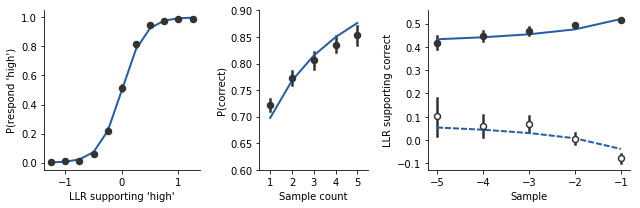

In [9]:
plot_behav_assays(pulse_data, m_linear)

### Extrema Detection model

In [10]:
m_extrema = ExtremaDetection()
m_extrema.fit_parameters(trial_data, pulse_data, [.3, .6])
print(m_extrema.params)

Free Parameters:
  sigma: 0.43
  theta: 0.508



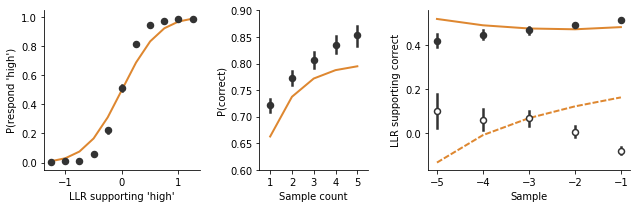

In [11]:
plot_behav_assays(pulse_data, m_extrema)

### Counting model

In [12]:
m_count = Counting()
m_count.fit_parameters(trial_data, pulse_data, [.3])
print(m_count.params)

Free Parameters:
  sigma: 0.367



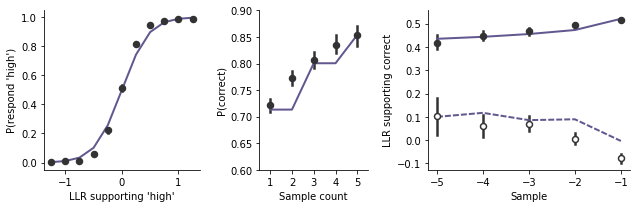

In [13]:
plot_behav_assays(pulse_data, m_count)

### Leaky integration model

In [14]:
m_leaky = LeakyIntegration()
m_leaky.fit_parameters(trial_data, pulse_data, [.3, .1, .1])
print(m_leaky.params)

Free Parameters:
  sigma_eta: 0.47
  sigma_eps: 8.7e-10
  alpha: 1.48e-15



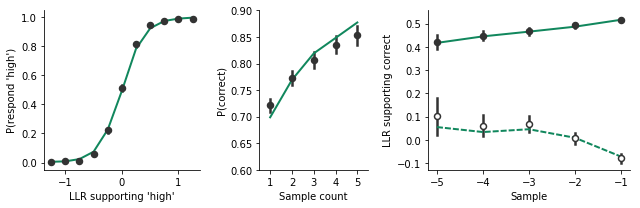

In [15]:
plot_behav_assays(pulse_data, m_leaky)